<a href="https://colab.research.google.com/github/Minh-A/Dacon_ArcticSeaIce_Prediction_2/blob/main/Code_8_Final_KNNR%20stacking%20NewData%20daily%20BetaFinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 함수

기초 함수

In [ ]:
# 그림을 그리는 함수

def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛 모양
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 둘째 자리에서 반올림하는 함수

def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 점수 계산
# 대회안내 - 규칙에 존재하는 산식 코드입니다.

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor  # 사용할 모델입니다.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')


Mounted at /content/drive/


추론 데이터 불어오기

In [ ]:
# 2020년 추론 데이터

# 테스팅용
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/public_weekly_test.csv')
dm1 = fn1.iloc[1:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/12150.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
inf2020 = data

In [ ]:
# 2021년 추론 데이터

# 테스팅용
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/private_weekly_test.csv')
dm1 = fn1.iloc[1:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/12202.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
inf2021 = data

100%|██████████| 23/23 [00:06<00:00,  3.44it/s]

(24, 448, 304)


파라미터 조정을 위한 데이터 셋 생성 (2020년)

In [ ]:
# 제출 데이터
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train.csv')
dm1 = fn1.iloc[2177:2177+11:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/12176.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
pa2020 = data

100%|██████████| 11/11 [00:09<00:00,  1.12it/s]

(12, 448, 304)


일별 훈련 데이터 불러오기

In [ ]:
# 일별 데이터 불러오기
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/daily_train.csv')
fn1.tail()

,date,file_nm
15577,2021-06-16,20210616.npy
15578,2021-06-17,20210617.npy
15579,2021-06-18,20210618.npy
15580,2021-06-19,20210619.npy
15581,2021-06-20,20210620.npy


# 일별 Target 데이터 불러오기

## 2020년 추론을 위한

> Public Score : 2020년 7월 6일 ~ 2020년 9월 27일(12주) 주별 해빙 농도 예측

In [ ]:
fn1.iloc[14867,0], fn1.iloc[14502,0]

('2019-07-07', '2018-07-07')

In [ ]:
# 훈련데이터 셋 생성 함수
def filemake(num,iii):  # num은 시작일보다 1일뒤로 적음
  dm = fn1.iloc[num:num+83,1]

  start = fn1.iloc[num-1,1]
  data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/daily_train/{}'.format(start))
  data = data.reshape(1,448,304,5)

  for i in dm:
     a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/daily_train/'+i)
     a = a.reshape(1,448,304,5)
     data = np.concatenate((data,a), axis=0)

  data = np.array(data)
  data = data[:,:,:,0]


  # train 데이터 셋 생성
  globals()['test_{}'.format(iii)] = data
  globals()['test2020_{}'.format(iii)] =   globals()['test_{}'.format(iii)].reshape(84,448,304)

  # 확인
  print(globals()['test2020_{}'.format(iii)].shape)

In [ ]:
# 2020년 추론 타겟 데이터 생성
lis = [14867, 14502] # 2019년~2018년

for i,datan in tqdm(enumerate(lis)):
  filemake(datan, i)

1it [01:29, 89.38s/it]

(84, 448, 304)


2it [02:30, 75.08s/it]

(84, 448, 304)


앙상블 2차 모델에 대한 타겟 데이터 생성

> 2019년 데이터가 2020년 예측을 위한 타겟 데이터가 됨

In [ ]:
# te2019 만들기

for i in range(12):
  globals()['te2019{}'.format(i)] = np.array([test2020_0[0 +(7*i)] , test2020_0[1 +(7*i)] , test2020_0[2 +(7*i)] , test2020_0[3 +(7*i)] , test2020_0[4 +(7*i)] , test2020_0[5 +(7*i)] , test2020_0[6 +(7*i)]]).mean(axis=0)
  print(globals()['te2019{}'.format(i)].shape)

(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)


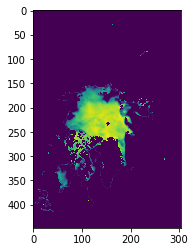

In [ ]:
# te2019 데이터 확인
plt.imshow( te20190 , interpolation = 'None')
plt.show()

## 2021년 추론을 위한

> Private Score : 2021년 7월 5일 ~ 2021년 9월 26일(12주) 주별 해빙 농도 예측

In [ ]:
fn1.iloc[15232,0], fn1.iloc[14866,0]

('2020-07-06', '2019-07-06')

In [ ]:
# 훈련데이터 셋 생성 함수
def filemake1(num,iii):  # num은 시작일보다 1일뒤로 적음
  dm = fn1.iloc[num:num+83,1]

  start = fn1.iloc[num-1,1]
  data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/daily_train/{}'.format(start))
  data = data.reshape(1,448,304,5)

  for i in dm:
     a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/daily_train/'+i)
     a = a.reshape(1,448,304,5)
     data = np.concatenate((data,a), axis=0)

  data = np.array(data)
  data = data[:,:,:,0]


  # train 데이터 셋 생성
  globals()['test_{}'.format(iii)] = data
  globals()['test2021_{}'.format(iii)] =   globals()['test_{}'.format(iii)].reshape(84,448,304)

  # 확인
  print(globals()['test2021_{}'.format(iii)].shape)

In [ ]:
# 2021년 추론 타겟 데이터 생성
lis = [15232, 14866] # 2020년~2019년

for i,datan in tqdm(enumerate(lis)):
  filemake1(datan, i)

1it [00:48, 48.12s/it]

(84, 448, 304)


2it [01:15, 37.86s/it]

(84, 448, 304)


앙상블 2차 모델에 대한 타겟 데이터 생성

> 2020년 데이터가 2021년 예측을 위한 타겟 데이터가 됨

In [ ]:
# te2020 만들기

for i in range(12):
  globals()['te2020{}'.format(i)] = np.array([test2021_0[0 +(7*i)] , test2021_0[1 +(7*i)] , test2021_0[2 +(7*i)] , test2021_0[3 +(7*i)] , test2021_0[4 +(7*i)] , test2021_0[5 +(7*i)] , test2021_0[6 +(7*i)]]).mean(axis=0)
  print(globals()['te2020{}'.format(i)].shape)

(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)


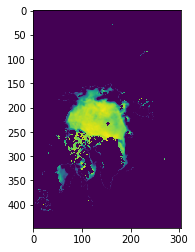

In [ ]:
# te2019 데이터 확인
plt.imshow( te20200 , interpolation = 'None')
plt.show()

# 2020년 예측 모델

## KNN 앙상블 모델1 (2020)

> 추론 데이터로 1차예측
* 해당년도의 12주를 예측 (전체 예측)

In [ ]:
# 2020년 추론 모델
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(2)):
  te = globals()['test2020_{}'.format(i)]

  # 데이터셋 나누기
  x_train = inf2020.reshape(24,-1).T
  y_train = te.reshape(84,-1).T
  x_test = inf2020.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=1202, weights='distance', p=2, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.T

  # 변수 저장
  globals()['pred2020_{}'.format(i)] = predictions
  print(globals()['pred2020_{}'.format(i)].shape)

 50%|█████     | 1/2 [10:33<10:33, 633.06s/it]

(84, 136192)


100%|██████████| 2/2 [20:54<00:00, 627.13s/it]

(84, 136192)


2019년, 2018년 예측으로 2차 모델의 데이터셋 생성

In [ ]:
# 84일 예측을 12주로 만드는 함수

def makeweek(name, prefile):

  pred = prefile

  # 84일을 12주로
  for i in range(12):
    globals()['week{}'.format(i)] = np.array([pred[0 +(7*i)] , pred[1 +(7*i)] , pred[2 +(7*i)] , pred[3 +(7*i)] , pred[4 +(7*i)] , pred[5 +(7*i)] , pred[6 +(7*i)]]).mean(axis=0)
    
  # 12주 데이터셋 생성
  name1 = pd.DataFrame(week0.reshape(1,-1))  # 초기값 설정

  for i in range(11):
    globals()['week{}'.format(i+1)] = globals()['week{}'.format(i+1)].reshape(1,-1)

    sh = globals()['week{}'.format(i+1)]
    sh = pd.DataFrame(sh)

    name1 = pd.concat((name1, sh), axis=0)

    globals()['{}'.format(name)] = name1
  print(globals()['{}'.format(name)].shape)

In [ ]:
# 2020년 1차 앙상블 모델 예측 데이터셋 생성
makeweek( 'm12019', pred2020_0)
makeweek( 'm12018', pred2020_1)

(12, 136192)
(12, 136192)


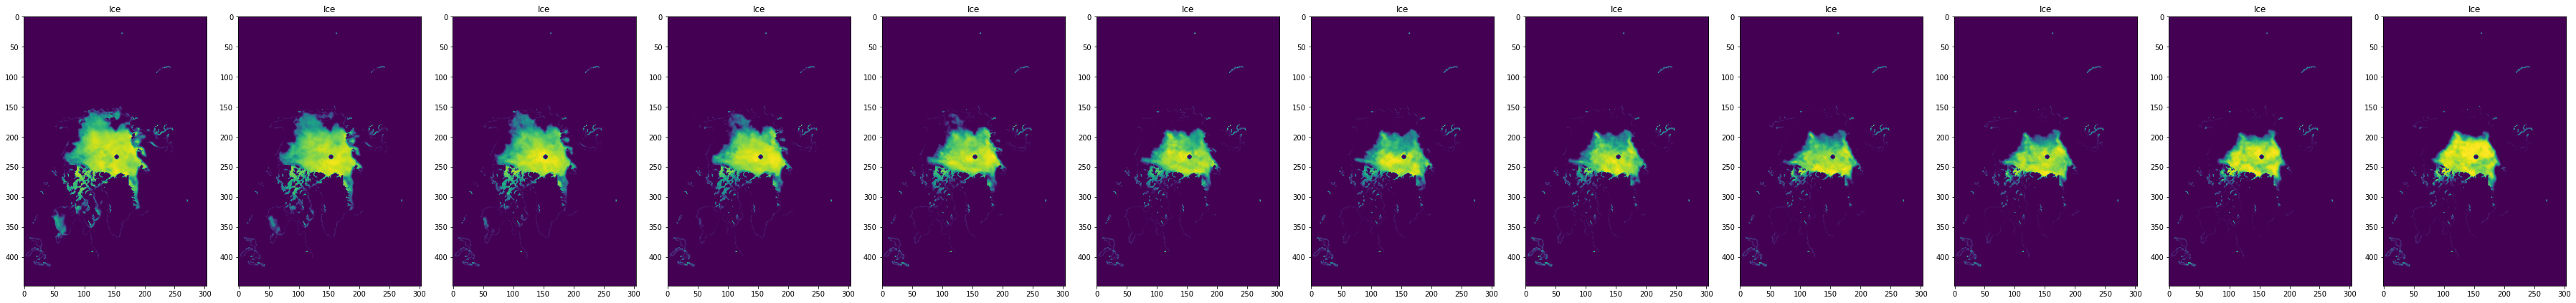

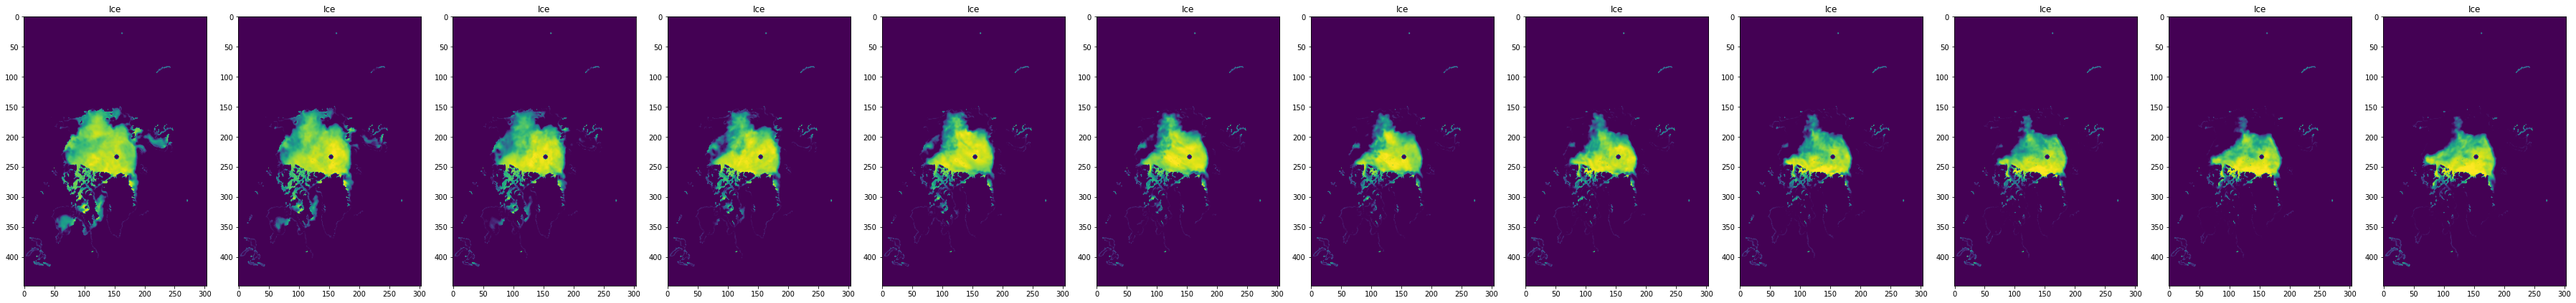

In [ ]:
show(np.array(m12019).reshape(12,448,304))
show(np.array(m12018).reshape(12,448,304))

예측 데이터 앙상블을 통한 데이터 셋 생성

> 2차 앙상블 모델에서 2020년으로 활용됨

In [ ]:
# 예측된 데이터를 앙상블
en2020 = np.array([pred2020_0, pred2020_1]).mean(axis=0)

In [ ]:
# 앙상블 데이터로 예측 데이터셋 생성 (2020년으로 추정함)
makeweek( 'm12020', en2020)

(12, 136192)


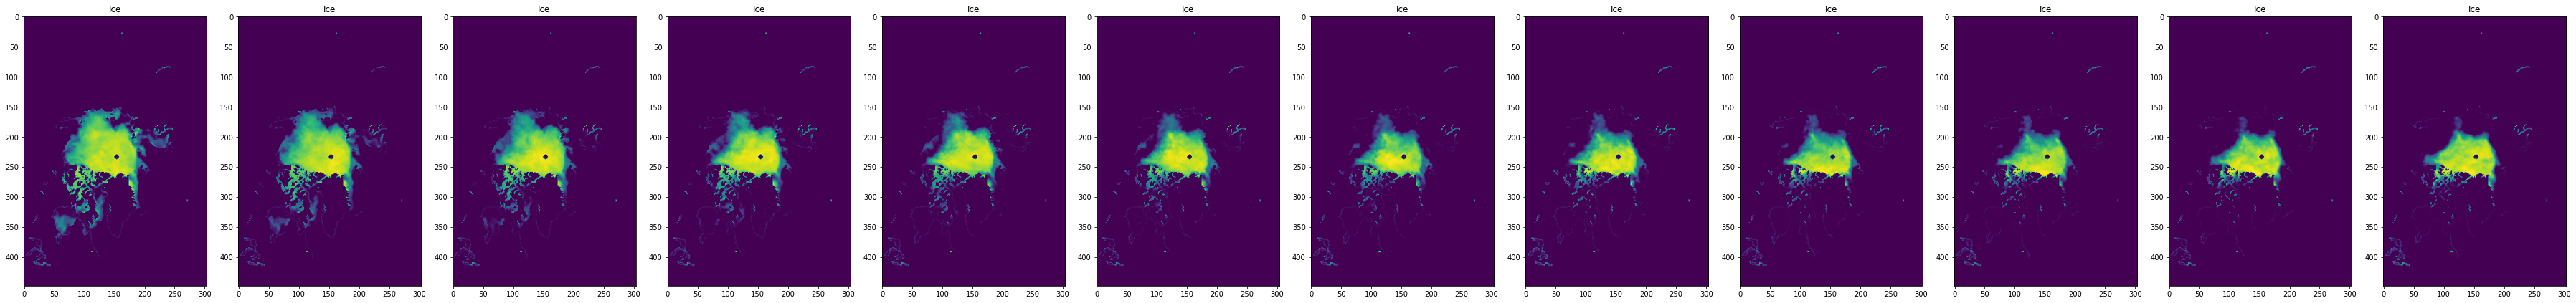

In [ ]:
show(np.array(m12020).reshape(12,448,304))

## 테스팅

In [ ]:
pd.DataFrame(np.unique(m12020))

,0
0,0.000000
1,0.041126
2,0.071429
3,0.082418
4,0.106061
...,...
3797,249.214286
3798,249.428571
3799,249.571429
3800,249.714286


In [ ]:
pd.DataFrame(np.unique(m12020))

,0
0,0.000000
1,0.041126
2,0.071429
3,0.082418
4,0.106061
...,...
3797,249.214286
3798,249.428571
3799,249.571429
3800,249.714286


파라미터 조정

In [ ]:
# 소숫점 둘째 자리에서 반올림하는 함수

def fun1(x) : 
  return np.around(x,2)

In [ ]:
def fun1(x) : 
  return np.ceil(x)

In [ ]:
makeweek( 'm12019', pred2020_0)

(12, 136192)


In [ ]:
real = np.array(pa2020)
a = np.array(sh1)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 3.3133699911399606 
 F1 : 0.7799396919389713 
 Final 4.248238656017571


In [ ]:
real = np.array(pa2020)
a = np.array(m12019)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 3.5414306579436885 
 F1 : 0.7185892885968274 
 Final 4.928309765896817


In [ ]:
real = np.array(pa2020)
a = np.array(m12019)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

In [ ]:
real = np.array(pa2020)
a = np.array(sh1)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

In [ ]:
# 제출 데이터
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train.csv')
dm1 = fn1.iloc[2124:2124+11:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/12123.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
pa2019 = data

100%|██████████| 11/11 [00:00<00:00, 291.99it/s]

(12, 448, 304)


In [ ]:
real = np.array(pa2020)
a = np.array(pa2019).reshape(12,-1)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 12.25362967966792 
 F1 : 0.742279823182575 
 Final 16.508099953530536


In [ ]:
def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score

## KNN 앙상블 모델 2 (2020)

> 예측된 데이터로 2차예측
* 각각의 12주를 예측 
* 각 주에 대한 2년 시계열이 사용됨

2차 앙상블 모델에 대한 데이터 전처리

In [ ]:
# 1차 예측 데이터로 데이터셋을 생성 (훈련데이터)
sh12018 = np.array(m12018)
sh12019 = np.array(m12019)

for i in tqdm(range(12)):
  globals()['pre{}'.format(i)] = np.array(np.concatenate((sh12018[i].reshape(1,448,304), sh12019[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre{}'.format(i)].shape)

100%|██████████| 12/12 [00:00<00:00, 425.32it/s]

(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)


In [ ]:
# 2차 앙상블 모델에 대한 테스트 데이터 생성
ens = np.array(m12020)

for i in tqdm(range(12)):
  globals()['pre2{}'.format(i)] = np.array(np.concatenate((sh12019[i].reshape(1,448,304), ens[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre2{}'.format(i)].shape)

100%|██████████| 12/12 [00:00<00:00, 515.95it/s]

(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)


2차 앙상블 모델

  0%|          | 0/12 [00:00<?, ?it/s]

(1, 136192)


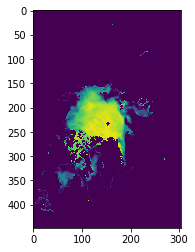

  8%|▊         | 1/12 [02:47<30:45, 167.74s/it]

(1, 136192)


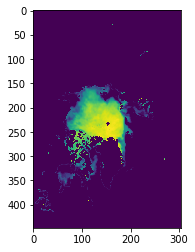

 17%|█▋        | 2/12 [05:33<27:50, 167.03s/it]

(1, 136192)


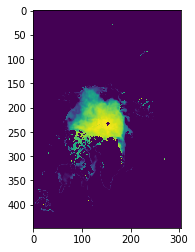

 25%|██▌       | 3/12 [08:24<25:15, 168.36s/it]

(1, 136192)


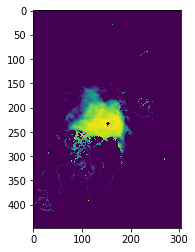

 33%|███▎      | 4/12 [11:16<22:36, 169.51s/it]

(1, 136192)


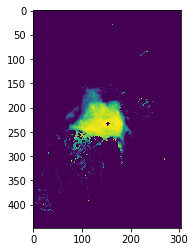

 42%|████▏     | 5/12 [14:13<20:02, 171.79s/it]

(1, 136192)


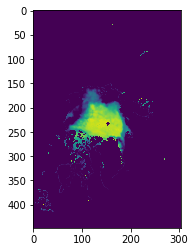

 50%|█████     | 6/12 [17:11<17:21, 173.56s/it]

(1, 136192)


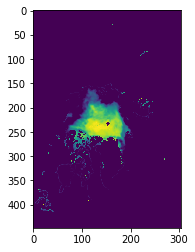

 58%|█████▊    | 7/12 [20:07<14:31, 174.29s/it]

(1, 136192)


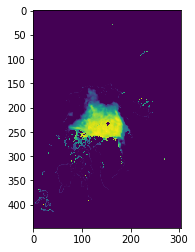

 67%|██████▋   | 8/12 [23:10<11:47, 176.83s/it]

(1, 136192)


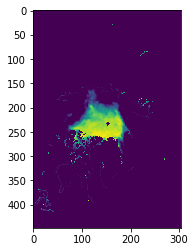

 75%|███████▌  | 9/12 [26:10<08:53, 177.87s/it]

(1, 136192)


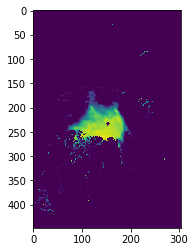

 83%|████████▎ | 10/12 [29:07<05:55, 177.54s/it]

(1, 136192)


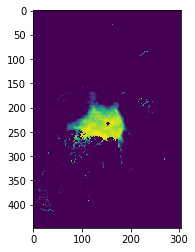

 92%|█████████▏| 11/12 [32:05<02:57, 177.84s/it]

(1, 136192)


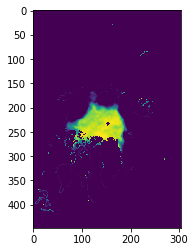

100%|██████████| 12/12 [35:04<00:00, 175.39s/it]


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  tr = globals()['pre{}'.format(i)]  # 앞서 예측된 2018년과 2019년
  te = globals()['te2019{}'.format(i)]  # 실제 2019년(daily2019)
  inf = globals()['pre2{}'.format(i)]  # 실제 2019년과 앙상블 2020년으로 예측을 실행

  # 데이터셋 나누기
  x_train = tr.reshape(2,-1).T
  y_train = te.reshape(1,-1).T
  x_test = inf.reshape(2,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=601, weights='distance', p=2, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(1,-1)

  # 변수 저장
  globals()['pred__{}'.format(i)] = predictions
  print(globals()['pred__{}'.format(i)].shape)

  # 그래프 표시
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

In [ ]:
# 제출 형태로 변환

# 데이터 생성
sh1 = pd.DataFrame(pred__0.reshape(1,-1))  # 초기값 설정
sh1 = fun1(sh1)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred__{}'.format(i+1)] = globals()['pred__{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred__{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh1 = pd.concat((sh1, sh), axis=0)
  print(sh1.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


# 2021년 예측 모델

## KNN 앙상블 모델1 (2021)

> 추론 데이터로 1차예측
* 해당년도의 12주를 예측 (전체 예측)

In [ ]:
# 2021년 추론 모델
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(2)):
  te = globals()['test2021_{}'.format(i)]

  # 데이터셋 나누기
  x_train = inf2021.reshape(24,-1).T
  y_train = te.reshape(84,-1).T
  x_test = inf2021.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=1202, weights='distance', p=2, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.T

  # 변수 저장
  globals()['pred2021_{}'.format(i)] = predictions
  print(globals()['pred2021_{}'.format(i)].shape)

 50%|█████     | 1/2 [11:10<11:10, 670.24s/it]

(84, 136192)


100%|██████████| 2/2 [22:12<00:00, 666.12s/it]

(84, 136192)


2020년, 2019년 예측으로 2차 모델의 데이터셋 생성

In [ ]:
# 84일 예측을 12주로 만드는 함수

def makeweek(name, prefile):

  pred = prefile

  # 84일을 12주로
  for i in range(12):
    globals()['week{}'.format(i)] = np.array([pred[0 +(7*i)] , pred[1 +(7*i)] , pred[2 +(7*i)] , pred[3 +(7*i)] , pred[4 +(7*i)] , pred[5 +(7*i)] , pred[6 +(7*i)]]).mean(axis=0)
    
  # 12주 데이터셋 생성
  name1 = pd.DataFrame(week0.reshape(1,-1))  # 초기값 설정

  for i in range(11):
    globals()['week{}'.format(i+1)] = globals()['week{}'.format(i+1)].reshape(1,-1)

    sh = globals()['week{}'.format(i+1)]
    sh = pd.DataFrame(sh)

    name1 = pd.concat((name1, sh), axis=0)

    globals()['{}'.format(name)] = name1
  print(globals()['{}'.format(name)].shape)

In [ ]:
# 2020년 1차 앙상블 모델 예측 데이터셋 생성
makeweek( 'm22020', pred2021_0)
makeweek( 'm22019', pred2021_1)

(12, 136192)
(12, 136192)


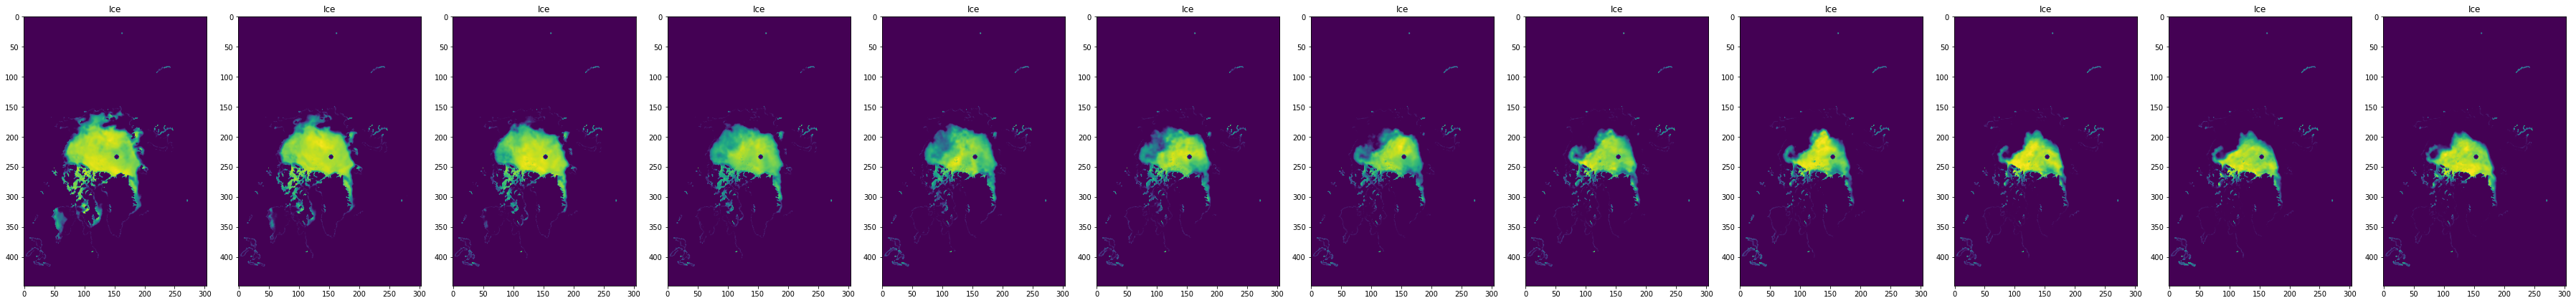

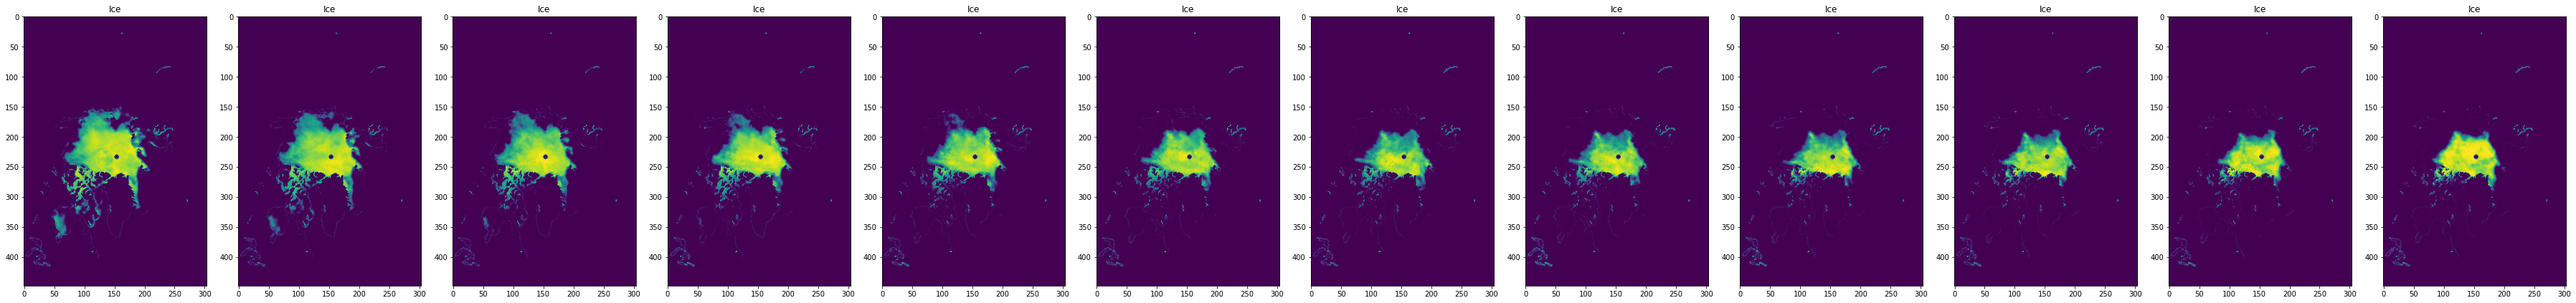

In [ ]:
show(np.array(m22020).reshape(12,448,304))
show(np.array(m22019).reshape(12,448,304))

예측 데이터 앙상블을 통한 데이터 셋 생성

> 2차 앙상블 모델에서 2020년으로 활용됨

In [ ]:
# 예측된 데이터를 앙상블
en2021 = np.array([pred2021_0, pred2021_1]).mean(axis=0)

In [ ]:
# 앙상블 데이터로 예측 데이터셋 생성 (2020년으로 추정함)
makeweek( 'm22021', en2021)

(12, 136192)


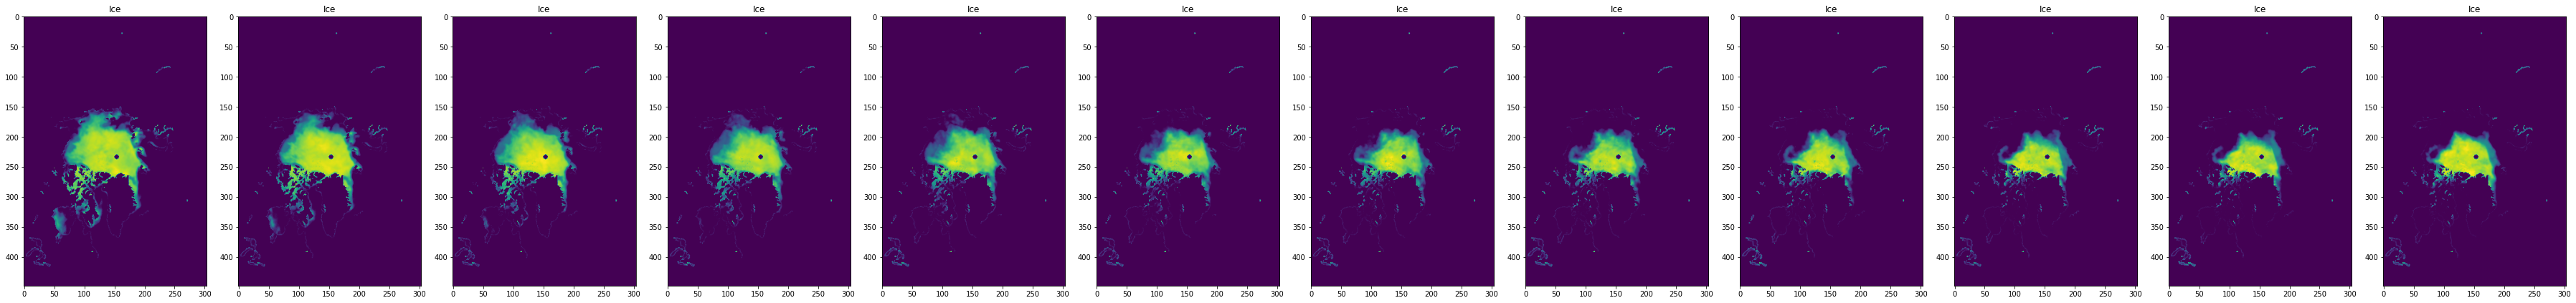

In [ ]:
show(np.array(m22021).reshape(12,448,304))

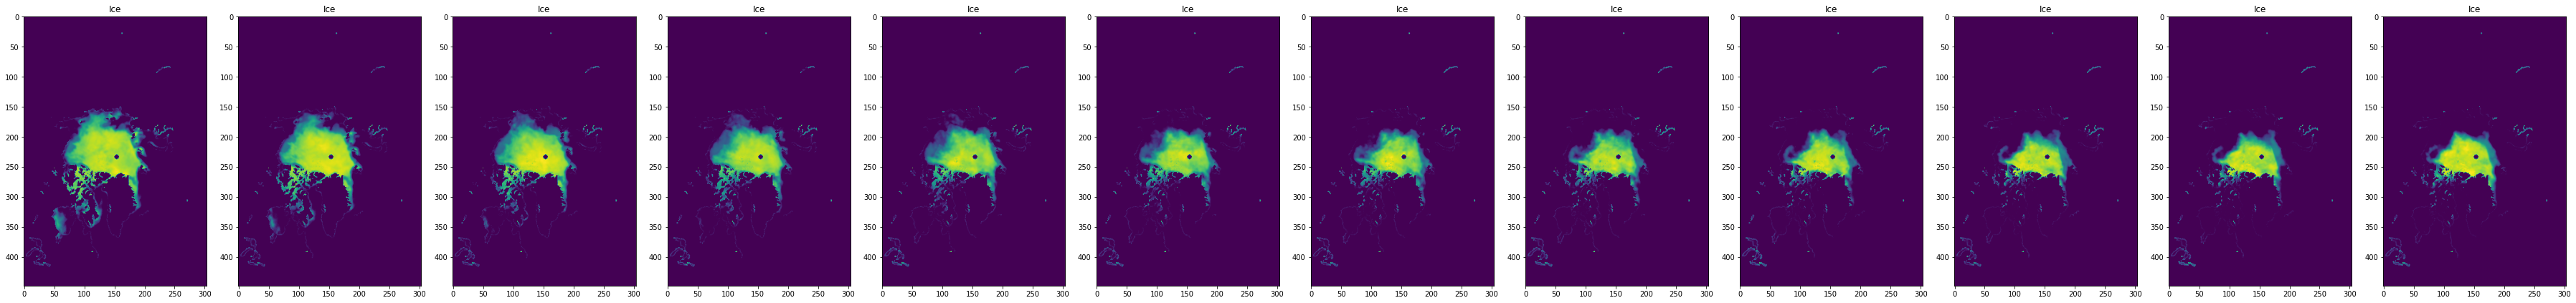

In [ ]:
show(np.array(m22021).reshape(12,448,304))

## KNN 앙상블 모델 2 (2021)

> 예측된 데이터로 2차예측
* 각각의 12주를 예측 
* 각 주에 대한 2년 시계열이 사용됨

2차 앙상블 모델에 대한 데이터 전처리

In [ ]:
# 1차 예측 데이터로 데이터셋을 생성 (훈련데이터)
sh22019 = np.array(m22019)
sh22020 = np.array(m22020)

for i in tqdm(range(12)):
  globals()['pre{}'.format(i)] = np.array(np.concatenate((sh22019[i].reshape(1,448,304), sh22020[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre{}'.format(i)].shape)

100%|██████████| 12/12 [00:00<00:00, 372.31it/s]

(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)


In [ ]:
# 2차 앙상블 모델에 대한 테스트 데이터 생성
ens = np.array(m22021)

for i in tqdm(range(12)):
  globals()['pre2{}'.format(i)] = np.array(np.concatenate((sh22020[i].reshape(1,448,304), ens[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre2{}'.format(i)].shape)

100%|██████████| 12/12 [00:00<00:00, 399.05it/s]

(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)
(2, 448, 304)


2차 앙상블 모델

  0%|          | 0/12 [00:00<?, ?it/s]

(1, 136192)


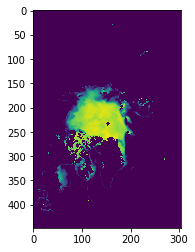

  8%|▊         | 1/12 [03:00<33:09, 180.83s/it]

(1, 136192)


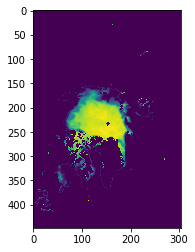

 17%|█▋        | 2/12 [06:03<30:14, 181.42s/it]

(1, 136192)


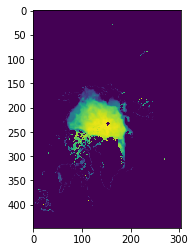

 25%|██▌       | 3/12 [09:11<27:28, 183.22s/it]

(1, 136192)


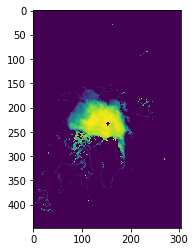

 33%|███▎      | 4/12 [12:21<24:44, 185.51s/it]

(1, 136192)


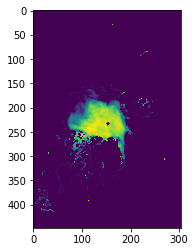

 42%|████▏     | 5/12 [15:33<21:51, 187.38s/it]

(1, 136192)


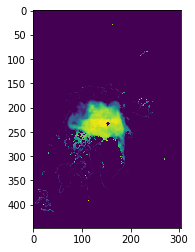

 50%|█████     | 6/12 [18:43<18:48, 188.04s/it]

(1, 136192)


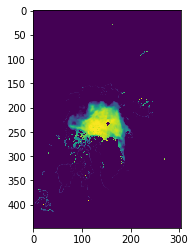

 58%|█████▊    | 7/12 [21:57<15:50, 190.02s/it]

(1, 136192)


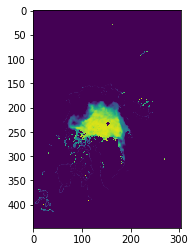

 67%|██████▋   | 8/12 [25:10<12:43, 190.80s/it]

(1, 136192)


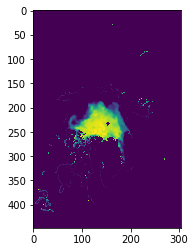

 75%|███████▌  | 9/12 [28:24<09:35, 191.71s/it]

(1, 136192)


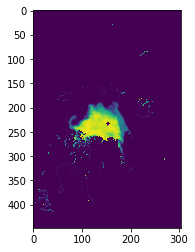

 83%|████████▎ | 10/12 [31:40<06:26, 193.06s/it]

(1, 136192)


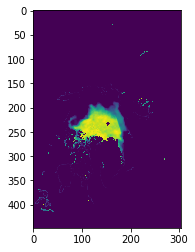

 92%|█████████▏| 11/12 [34:57<03:14, 194.34s/it]

(1, 136192)


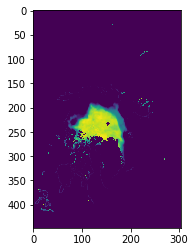

100%|██████████| 12/12 [38:13<00:00, 191.12s/it]


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  tr = globals()['pre{}'.format(i)]  # 앞서 예측된 2019년과 2020년
  te = globals()['te2020{}'.format(i)]  # 실제 2020년(daily2020)
  inf = globals()['pre2{}'.format(i)]  # 실제 2020년과 앙상블 2021년으로 예측을 실행

  # 데이터셋 나누기
  x_train = tr.reshape(2,-1).T
  y_train = te.reshape(1,-1).T
  x_test = inf.reshape(2,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=601, weights='distance', p=2, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(1,-1)

  # 변수 저장
  globals()['pred__{}'.format(i)] = predictions
  print(globals()['pred__{}'.format(i)].shape)

  # 그래프 표시
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

In [ ]:
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(pred__0.reshape(1,-1))  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred__{}'.format(i+1)] = globals()['pred__{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred__{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2 = pd.concat((sh2, sh), axis=0)
  print(sh2.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


# 제출

앙상블에 대한 제출

In [ ]:
aaa1 = fun1(sh1)

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([aaa1,aaa1], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data_v2/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

,week_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
19,2021-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2021-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2021-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2021-09-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2021-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Real 제출물 생성

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([sh1,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

,week_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
19,2021-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2021-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2021-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2021-09-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2021-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Lets Final Check')

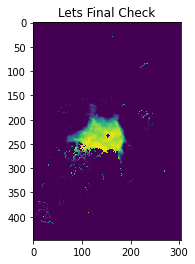

In [ ]:
# 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/result/sub_0629_2_KNN(L2_L2_final).csv', index = False)

수고하셨습니다. ( ⁎ ᵕᴗᵕ ⁎ )

 --------------------

---------------------------